In [1]:
from sympy.physics.vector import Point,ReferenceFrame as rf
from sympy.physics.mechanics import  inertia, RigidBody, Lagrangian, LagrangesMethod, Particle, angular_momentum
from sympy.physics.mechanics import KanesMethod, Dyadic
from sympy.physics.vector import dynamicsymbols
from sympy import Matrix, symbols, simplify,diff, solve
from sympy.physics.vector import init_vprinting
init_vprinting(pretty_print=True)
import sympy as sp
from sympy import lambdify
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib.patches import Rectangle
import os
import time
import control as ct
from control import lqr
import numpy as np
from numpy import linalg as la
from numpy import rad2deg, deg2rad
from numpy.linalg import inv,pinv
import scipy
from scipy.integrate import odeint
from scipy.optimize import minimize
import math as m
from scipy.interpolate import CubicSpline
from scipy.interpolate import BSpline
from itertools import islice
from numpy.linalg import inv 
Mc,lc,Ix,Iy,Iz,Ixz,K,J = symbols('M_c,l_c,I_x,I_y,I_z,I_xz,K,J')
q1,q4, ql,qb,phi = dynamicsymbols(' q1 q4 ql q_b phi')
qa1, qa2 = dynamicsymbols('qa1,qa2')
qr, ql,x,y,z = dynamicsymbols('q_r,q_l,x,y,z')
bt = symbols('beta')
l12, l13 , l34, l25, l24,l01= symbols("l12 l13 l34 l25 l24 l01")
r ,g, d,kt,t = symbols("r g d kt t")
la1, la2,lm1,lm2,lm3,lm4 = symbols('la1 la2 lm1 lm2 lm3,lm4')
mb, m1,m2,m3,m4,mw, ma1, ma2, mext = symbols('mb m1 m2 m3 m4 mw ma1 ma2 mext')
Tl,Tr = symbols('Tl Tr')
phi, th = dynamicsymbols('phi,theta')
Tw,Tm,Ta1,Ta2 = symbols('Tw,Tm,Ta1,Ta2')
xc,yc,phi,x = dynamicsymbols('xc yc phi x')
values = {
            mw:0.268, m1: 0.127, m2 : 0.105, m3:0.103, mb: 1.512, ma1:0.092526,ma2:0.109,
            l01: 0.190, l12: 0.050, l24:0.193, l13: 0.188, l34:0.093, la1:0.20, la2:0.20,
            r:0.070, g:9.81, d:0.210, bt: np.deg2rad(46.1),
            Mc: 2.919
}
vvalues = {kt :0.85}

In [2]:
def vectomat(vector,N,s=0):
    if s==0:
        return simplify( Matrix([vector.dot(N.x), vector.dot(N.y), vector.dot(N.z)]))
    else:
        return  Matrix([vector.dot(N.x), vector.dot(N.y), vector.dot(N.z)])
def rtang(alpha):
    if alpha>0:
        alpha = alpha
    else:
        alpha = alpha+np.pi
    return alpha   

def fourbar(t3):
    tm = t3-np.pi+values[bt]
    l = values[l13]; h =values[l34]
    g = values[l24]; f = values[l12]
    ln = np.sqrt(l**2+h**2-2*l*h*m.cos(tm))
    alpha = m.acos((g**2+f**2-ln**2)/(2*g*f))
    alpha = rtang(alpha)
    gamma = m.acos( ( h**2+  ln**2-  l**2)/(2*h*ln) )+\
            m.acos( ( g**2 + ln**2 - f**2)/(2*g*ln) )
    
    gamma = rtang(gamma)
    lembda = 2*np.pi- (gamma + alpha + tm)
    #                   q2        q3      q4
    return np.array([np.pi-alpha, lembda, t3])
def spround(exp,n=3):
    exp =exp.expand()
    for a in sp.preorder_traversal(exp):
        if isinstance(a, sp.Float):
            exp = exp.subs(a, round(a, n))
    return exp

In [3]:
q3 = sp.Function('q3')(q4)
q2 = sp.Function('q2')(q4)
q2

In [4]:
q=Matrix([xc,yc,phi,ql,qr,q1,q4,qa1,qa2])
qdot = q.diff()
lq = len(q)

In [5]:
N = rf('N')
C = N.orientnew('C','Axis',[phi,N.z])
Lw = C.orientnew('Lw','Axis',[ql,-C.y])
Rw = C.orientnew('Rw','Axis',[qr,-C.y])
L1 = C.orientnew('L1','Axis',[q1,-C.y])
L2 = L1.orientnew('L2','Axis',[q2,-L1.y])
L3 = L1.orientnew('L3','Axis',[q3,-L1.y])
B = L3.orientnew('B','Axis', [q4,-L3.y])
L4 = B.orientnew('L4','Axis',[bt,-B.y])
A1 = B.orientnew('A1','Axis',[qa1,-B.y])
A2 = A1.orientnew('A2','Axis',[qa2,-A1.y])

In [6]:
G = Point('G')
G.set_vel(N,0)
Cb = G.locatenew('Cb',xc*N.x+yc*N.y+r*N.z)
p0 = Cb.locatenew('p0',  d/2*C.y)
pc1 = p0.locatenew('pc1',-r*N.z)
p1 = p0.locatenew('p1',l01*L1.x)
p2 = p1.locatenew('p2',l12*L1.x)
p3 = p1.locatenew('p3',l13*L3.x)
p34 = p3.locatenew('p34',l34*L4.x)
p24 = p2.locatenew('p24',l24*L2.x)

p01 = Cb.locatenew('p01',-d/2*C.y)
pc2 = p01.locatenew('pc2',-r*N.z)
p11 = p01.locatenew('p11',l01*L1.x)
p21 = p11.locatenew('p21',l12*L1.x)
p31 = p11.locatenew('p31',l13*L3.x)
p341 = p31.locatenew('p341',l34*L4.x)
p241 = p21.locatenew('p241',l24*L2.x)

pb = p3.locatenew('pb',-6.501/1000*B.x+147/1000*B.z-d/2*B.y)
pa1 =pb.locatenew('pa1',la1*A1.x)
pa2 =pa1.locatenew('pa2',la2*A2.x)

rec_cen = pb.locatenew('rec',-0.186/2*B.x\
                       -0.186*B.z
                       )

In [7]:
c1 = p0.locatenew('c1',0.130055*L1.x)
c2 = p2.locatenew('c2',0.102766*L2.x)
c3 = p1.locatenew('c3',0.097766*L3.x)

c11 = p01.locatenew('c1',0.130055*L1.x)
c21 = p21.locatenew('c2',0.102766*L2.x)
c31 = p11.locatenew('c3',0.097766*L3.x)

cb = pb.locatenew('cb',-0.017192*B.x-0.085*B.z)
ca1 = pb.locatenew("ca1",0.080669*A1.x)
ca2 = pa1.locatenew("ca2",0.103429*A2.x)

In [8]:
q.T

In [9]:
## coordinates 
qinput = Matrix([xc,yc,phi,q1,q2,q3,q4,qa1,qa2])

points = [p0,p1,p2,p24,p3,p34,pb,pa1,pa2,rec_cen]
robocord = []
for pnt in points:
    robocord.append(vectomat(pnt.pos_from(G),N,1).T)

robocord= Matrix(robocord).T
robocord.row_del(1)
robopoints = lambdify(qinput,robocord.subs(values),modules='numpy')

cpoints = [c1,c2,c3,cb,ca1,ca2]
robocom = []
for pnt in cpoints:
    robocom.append(vectomat(pnt.pos_from(G),N,1).T)
robocom= Matrix(robocom).T
robocom.row_del(1)
robocpoints = lambdify(qinput,robocom.subs(values),modules='numpy')

In [10]:
def plotline(q):
    fig, ax = plt.subplots()
    points = robopoints(*q)
    pnts1 = points[:,:4]
    pnts2 = np.hstack((points[:,1:2],points[:,4:6]))
    pnts3 = points[:,6:-1]
    ax.plot(pnts1[0,:],pnts1[1,:],color='r')
    ax.plot(pnts2[0,:],pnts2[1,:],color='b')
    ax.plot(pnts3[0,:],pnts3[1,:],color='g')
    circle = plt.Circle((pnts1[0,0],pnts1[1,0]),0.07)
    squre = Rectangle((points[0,9],points[1,9]),0.186,0.186,angle = rad2deg(q[3]+q[5]+q[6]))
    ax.add_patch(squre)
    ax.add_artist(circle)
    plot([-0.25,0.6],[0,0],'k')
    ax.set_xlim([-0.3,0.8])
    ax.set_ylim([-0.3,0.8])
    axis('equal')
    return fig, ax
def plotcom(q):
    points = robocpoints(*qinput)
    plot(points[0,:],points[1,:],'ko')

In [11]:
def com():
    cn = [c1,c2,c3,cb,ca1,ca2,c11,c21,c31]
    mn = [m1,m2,m3,mb,ma1,ma2,m1,m2,m3]
    cm = Matrix([[0,0,0]]).T
    for i in range(len(cn)):
        cm += vectomat(cn[i].pos_from(G),N,1)*mn[i]
    return (cm/sum(mn)).subs(values)
com_N = lambdify(qinput,com(),modules='numpy')

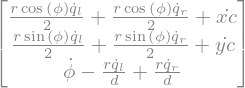

In [12]:
Vb = Cb.set_vel(N,diff(xc)*N.x+diff(yc)*N.y)
p0.v2pt_theory( Cb, N,C)
p01.v2pt_theory(Cb,N,C)

vc1 = pc1.v2pt_theory(p0, N,Lw)
vc2 = pc2.v2pt_theory(p01,N,Rw)
nonhol = Matrix.vstack(vectomat(vc1,N)[:2,:],vectomat(vc2,N)[:2,:])
sol = solve(nonhol[:3,:],[diff(xc),diff(yc),diff(phi)])
nonhol = (Matrix(list(sol.keys())) - Matrix(list(sol.values()))).jacobian(qdot)@qdot
nonhol

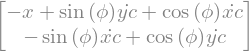

In [13]:
eq= vectomat(Cb.vel(N),C)[:2,:]- Matrix([x,0])
eq

In [14]:
Iw1 = inertia(Lw, 3.440*1e-04, 6.600*1e-03, 3.440*1e-04)
I24 = inertia(L2, 4401.69*1e-9, 3.489*1e-4, 3.463*1e-4) 
I02 = inertia(L1, 5301.652*1e-9, 6.561*1e-4, 6.530*1e-4) 
I13 = inertia(L3, 4289.19*1e-9, 3.233*1e-4, 3.208*1e-4) 
IB =  inertia(B,  1.584*1e-2, 1.357*1e-2, 1.285*1e-2,-80491.519*1e-9,0,0) 
Ia1 = inertia(A1,3822.08*1e-9, 2.383*1e-4, 2.359*1e-4) 
Ia2 = inertia(A2, 4592.809*1e-9, 3.906*1e-4, 3.879*1e-4) 

In [15]:
gravity = -g*N.z

In [16]:
link1= RigidBody('link1', c1, L1, m1, (I02, c1))
link2= RigidBody('link2', c2, L2, m2, (I24, c2))
link3= RigidBody('link3', c3, L3, m3, (I13, c3))

link11= RigidBody('link11', c11, L1, m1, (I02, c11))
link21= RigidBody('link21', c21, L2, m2, (I24, c21))
link31= RigidBody('link31', c31, L3, m3, (I13, c31))

arm1 = RigidBody('arm1', ca1, A1, ma1, (Ia1, ca1))
arm2 = RigidBody('arm2', ca2, A2, ma2, (Ia2, ca2))
base = RigidBody('Base', cb, B, mb, (IB, cb))
wheel_l= RigidBody('wheel_1', p0, Lw, mw, (Iw1, p0))
wheel_r= RigidBody('wheel_1', p01, Rw, mw, (Iw1, p01))
spring1 = Particle('spring1', p1, 0)
spring2 = Particle('spring1', p11, 0)

# Potenial Energy of Rigid Bodies

wheel_l.potential_energy = -mw*gravity.dot(p0.pos_from(G))
wheel_r.potential_energy = -mw*gravity.dot(p01.pos_from(G))

link1.potential_energy = -m1*gravity.dot(c1.pos_from(G))
link2.potential_energy = -m2*gravity.dot(c2.pos_from(G))
link3.potential_energy = -m3*gravity.dot(c3.pos_from(G))

link11.potential_energy = -m1*gravity.dot(c11.pos_from(G))
link21.potential_energy = -m2*gravity.dot(c21.pos_from(G))
link31.potential_energy = -m3*gravity.dot(c31.pos_from(G))

arm1.potential_energy = -ma1*gravity.dot(ca1.pos_from(G))
arm2.potential_energy = -ma2*gravity.dot(ca2.pos_from(G))
base.potential_energy = -mb*gravity.dot(cb.pos_from(G))

spring1.potential_energy = 1/2*kt*(q3)**2
spring2.potential_energy = 1/2*kt*(q3)**2

In [17]:
## EOM
lag = Lagrangian(N,link1,link2,link3,
                   link11,link21,link31,
                   arm1,arm2,
                   wheel_l,wheel_r,
                   base,
                   spring1,spring2)
LM= LagrangesMethod(lag,q,nonhol_coneqs=nonhol,frame=N)
eom= LM.form_lagranges_equations()

c:\Users\itisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sympy\physics\vector\point.py:574: UserWarning: Velocity automatically calculated based on point p0 but it is also possible from points(s):[c2]. Velocities from these points are not necessarily the same. This may cause errors in your calculations.
  warn('Velocity automatically calculated based on point ' +
c:\Users\itisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sympy\physics\vector\point.py:574: UserWarning: Velocity automatically calculated based on point p01 but it is also possible from points(s):[c2]. Velocities from these points are not necessarily the same. This may cause errors in your calculations.
  warn('Velocity automatically calculated based on point ' +
c:\Users\itisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sympy\physics\vector\point.py:574: UserWarning: Velocity automatically calculated based on point p0 but it is also possible from points(s):[c3, c2]. Velocities fr

In [18]:
msai = LM.mass_matrix
Mq= msai[:,:lq]
Cq = (-LM.forcing)
sai = msai[:,lq:].T
said = diff(sai,t)

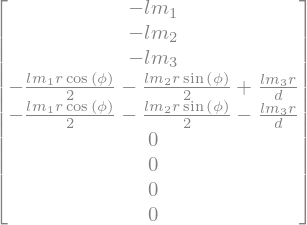

In [19]:
lm = Matrix([lm1,lm2,lm3])
sai.T@lm

In [20]:
solm = dict( zip( [lm1,lm2,lm3], -( Mq@diff(q,t,2))[:3,:] - Cq[:3,:]   ))
solx = { diff(xc) : diff(x)*sp.cos(phi), diff(xc,t,2):diff(sp.cos(phi)*diff(x)),
         diff(yc) : diff(x)*sp.sin(phi), diff(yc,t,2):diff(sp.sin(phi)*diff(x)) }
solw = solve(nonhol.subs(solx),diff(Matrix([yc,ql,qr]),t,1))
sola = solve(diff(nonhol,t),diff(Matrix([yc,ql,qr]),t,2))
solqlr = {sp.sin(ql):0,sp.sin(qr):0,sp.cos(ql):0,sp.cos(qr):0}

In [21]:
# lms = Matrix(list(solm.values()))
Iforce = (Mq@diff(q,t,2) + Cq)
holConstForces = sai.T@lm
# eom = (Iforce - holConstForces)[3:,:].subs(solm).subs(sola).subs(solw).subs(solx).subs(solqlr).subs(values)
eom = (Iforce - holConstForces)[3:,:].subs(solm).subs(sola).subs(solw).subs(solx).subs(solqlr)

In [22]:
qind = Matrix([x,phi,q1,q4,qa1,qa2])
Mqs  = sp.zeros(6,6)
for i in range(6):
    for j in range(6):
        Mqs[i,j] = diff(eom[i],diff(qind,t,2)[j])
Mqs = Mqs.subs(values)
Cqs= eom.subs(dict( zip( diff(qind,t,2), sp.zeros(len(qind),1))) )
Gs = Cqs.subs(dict( zip( diff(qind,t), sp.zeros(len(qind),1))) )

In [55]:
us = Matrix([Tl,Tr,-Tl-Tr,2*Tm,Ta1,Ta2])
usfun = sp.lambdify([Tl,Tr,Tm,Ta1,Ta2],us,modules = 'numpy')

In [164]:
qdep = Matrix([q2,q3,diff(q2,q4), diff(q3,q4),diff(q2,q4,2), diff(q3,q4,2)])
qn = Matrix.vstack(qind,qind.diff(),qdep )
Mqn = lambdify(qn,Mqs,modules='numpy')
cqn = lambdify(qn,Cqs.subs(vvalues),modules='numpy')
gn = lambdify(qn,Gs.subs(vvalues),modules='numpy')

In [ ]:
def Qconv(q): # 3 9
    q = np.array(q)
    #   x  phi q1 q4 qa1 qa2
    qder  = np.array([ f2(q[3]), f3(q[3]), f2(q[3],1), f3(q[3],1), f2(q[3],2), f3(q[3],2)])
    return np.append(q,qder)

def operatingPoint(q0,q1):
    def Constfun(qu):
        q = np.append(qu[:5] , np.zeros((6,)))
        q = np.insert(q, 2, [q1])
        u = qu[5:]
        x = Qconv(q)
        x2 = -gn(*x) + usfun(*u)
        return x2.reshape(-1,)
        
    def objfun(qu):
        u = qu[5:]
        return np.linalg.norm(u)
    bounds = [(None,None),(None,None),
            #   (0.534,1.0276) ,
               (3.55840321, 3.99440321),
            #   (None,None),(None,None)
              (np.pi/3,np.pi-np.pi/3),(None,None)
              ] + [(None,None)]*(5)
    const = {'type':'eq','fun': Constfun}
    sol = minimize(objfun, q0, bounds = bounds, constraints = const )
    opoints = np.insert(sol['x'],2,[q1])
    print('const',Constfun(sol['x']))
    return opoints,sol
                          # x phi q4        qa1        qa2           Tw Tr Tm Ta1 Ta2
q0 = np.append( np.array([0, 0,   3.900e+00, 2.338e+00,  5.387e-01]), np.zeros((5,)) )
qpoint,_ = operatingPoint( q0,q1 = np.pi/4 )
rcParams['figure.figsize'] = (6,4)
ccc(qpoint)
qpoint

In [168]:
def fun(x,u):
    q  = Qconv(x)
    u = usfun(*u)
    x2 = x[6:]
    f1 = x2
    f2 = np.dot( inv(Mqn(*q)), (-cqn(*q) + u ) )
    return np.append(f1,f2)

def Linearize(fun,x0,u0,eps=1e-08):
    A = np.zeros((len(x0),len(x0)))
    B = np.zeros((len(x0),len(u0)))
    
    for i in range(len(x0)):
        xn = x0.copy()
        xn[i] += eps
        A[:,i] = (fun(xn,u0)-fun(x0,u0))/eps
    
    for i in range(len(u0)):
        un = u0.copy()
        un[i] += eps
        B[:,i] = (fun(x0,un)-fun(x0,u0))/eps
    return A,B
x0 = np.append(qpoint[:6],np.zeros((6,)))
u0 = qpoint[6:]
A,B = Linearize(fun,x0,u0)
np.linalg.matrix_rank(ct.ctrb(A,B))

12